# Non-homogenous 1D Elastic Wave Equation 
In order to explote finite volume solvers we seek to investigate the 1-D elastic wave equation propogating through a non-homogenous medium. The source free elastic wave equation can be written a coupled sytems of equation 

$$
\begin{equation}
    \frac{\partial}{\partial t} \sigma - \mu \frac{\partial}{\partial x} v = 0  \:\:\:\:\:\: (1) \\
     \frac{\partial}{\partial t} v - \frac{1}{\rho} \frac{\partial}{\partial x} \sigma = 0 \:\:\:\:\:\: (2) \\
\end{equation}
$$

where $\sigma = \sigma_{xy}(x,t)$ is the shear stress component of the stress tensor, $v = v_y(x,t)$ is the transerve velocity, $\rho$ is the density and $\mu$ is the bulk modulus. 

In [24]:
import numpy as np 
from scipy import linalg as LA 
import matplotlib.pyplot as plt 
from matplotlib import animation, rc
rc('animation', html='jshtml')


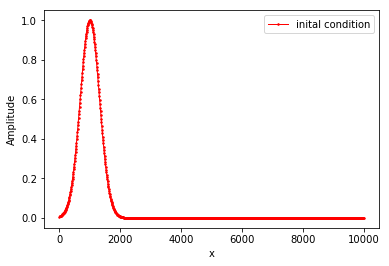

In [34]:
# Model Domain 
# -----------------------------------------------------
nx  = 1000              # number of grid cells
L   = 10*1000           # domain length (m)
cfl = 0.9               # Counrant Number 
T   = 2                 # length of simulation (s)

# Material Properties 
# -----------------------------------------------------
C   = 2500              # velcoity (m/s) 
rho = 2500              # density  (kg/m^3) 
Z   = rho*C             # impedance (kg/(s m^2))
mu  = rho*C**2          # bluk modulus 

# Inital Conditions
# -----------------------------------------------------
bet = 5e-6              # arugments in initial cond.
gam = 2e-5              # arugments in initial cond.
x0  = 1000              # postion of the initial conidition 

# Heterogenous Set Up
# --------------------------------------------------------------------------  
A = np.zeros((2,2,nx))
Z = np.zeros(nx)
c = np.zeros(nx)

# Spatially dependent velocity
c = c + C
c[int(nx/2):nx] = c[int(nx/2):nx]*3.

Z = rho*c

for i in range(1,nx):
    if i > nx/2:
        A[:,:,i] = np.array([[0, -mu],[-1/rho,0]])
    else:
        A[:,:,i] = np.array([[0, -4*mu],[-1/rho,0]])
    
# Initalizing spatial domain 
x, dx = np.linspace(0,L,nx,retstep=True)

# Calculate time step based on CFL criterion 
dt  = cfl*dx/c.max()
nt  = int(np.floor(T/dt))

# Initalize solution matrix
Q   = np.zeros((2,nx,nt))
#Q_n = np.zeros((2,nx,nt))

# Inital condition
# -----------------------------------------------------
Q[0,:,0]  = np.exp(-bet * (x-x0)**2) * np.cos(gam * (x - x0))

# Plot inital condition
# -----------------------------------------------------
plt.plot(x,  Q[0,:,0],'r-o', lw=1, markersize=1.5,  label="inital condition")
plt.ylabel('Amplitude')
plt.xlabel('x')
plt.legend()

### Lax-Wefford 

A second order numerical method

$$
\begin{equation}
      Q_j^{n+1} = Q_j^{n} - \frac{\Delta t}{2 \Delta x} A \left[\Delta Q_{j+1} - \Delta Q_{j-1} \right] + \frac{1}{2} \left( \frac{\Delta t}{\Delta x}\right)^2 A^2 \left(Q_{j+1}^n - 2Q_j^n + Q^n_{j-1}\right)
\end{equation}  
$$

In [35]:
# Lax-Wendroff scheme 
# -----------------------------------------------------
for n in range(nt-1):
    for j in range(1,nx-1):  
        dQ1 = Q[:,j+1,n] - Q[:,j-1,n]
        dQ2 = Q[:,j+1,n] - 2*Q[:,j,n] + Q[:,j-1,n]
        Q[:,j,n+1] = Q[:,j,n] - 0.5*(dt/dx) * A[:,:,i].dot(dQ1) +\
                     0.5*(dt/dx)**2 * (A[:,:,i]@A[:,:,i]).dot(dQ2)
        
    Q[:,0,n+1]  = Q[:,-2,n+1]
    Q[:,-1,n+1]  = Q[:,1,n+1]

In [36]:
fig, ax1 = plt.subplots(1,1, figsize=(10,6))

ax2 = ax1.twinx()

ax1.axvspan(((nx-1)/2+1)*dx, nx*dx, alpha=0.2, facecolor='b')


line1, = ax1.plot([], [], lw=2)
line2, = ax2.plot([], [], lw=2, color='r')
line = [line1, line2]

ax1.set_xlim((0, L))
ax2.set_xlim((0, L))

ax1.set_ylim((-1, 1.1))
ax2.set_ylim((-1e-7, 1.1e-7))

def animate(i):  
    global x,Q
    line[0].set_data(x, Q[0,:,i])
    line[1].set_data(x, Q[1,:,i])
    return line

anim = animation.FuncAnimation(fig, animate, 
                               frames=range(0,nt,10), interval=40, blit=True)
plt.close()
anim